# Difference Maps

In [1]:
from adjustText import adjust_text
import contextily as ctx
import csv
from datetime import datetime
import folium
from functools import partial
import geojson
import geopandas as gpd
from geopandas.tools import geocode
from geopy.geocoders import Nominatim
import io
from io import StringIO
import json
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import multiprocessing as mp
from multiprocessing import Pool
import numpy as np
import operator
import os
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import seaborn as sns
from shapely import wkt
from shapely.geometry import Point, LineString, Polygon, MultiPolygon
from sqlalchemy import create_engine, func, distinct
import sys
import tempfile
import warnings
# filter out RuntimeWarnings, due to geopandas/fiona read file spam
# https://stackoverflow.com/questions/64995369/geopandas-warning-on-read-file
warnings.filterwarnings("ignore",category=RuntimeWarning)

In [2]:
# Colors
cmap_grey = mpl.cm.get_cmap('Greys')
cmap_blue = mpl.cm.get_cmap('Blues')
cmap_red = mpl.cm.get_cmap('Reds')
loss_color = cmap_red(0.8,1)
same_color = cmap_grey(0.4,0.7)
border_color = cmap_blue(0.75,0.7)
gain_color = cmap_blue(0.8,1)

In [3]:
# Cities to plot
cities_list = ['Copenhagen, Denmark','Malmö, Sweden','Oslo, Norway','Helsinki, Finland','Stockholm, Sweden','Tornio, Finland','Haparanda, Sweden','Göteborg, Sweden', 'Tromsø, Norway','Bergen, Norway', 'Århus, Denmark','Stavanger,Norway','Reykjavik, Iceland', 'Trondheim, Norway', ' Vasa, Bangatan, Finland','Umeå, Sweden','Oulu, Finland','Sundsvall, Sweden','Turku, Finland', 'Kiruna, Sweden','Ålborg, Denmark','Luleå, Sweden', 'Rovaniemi, Finland', 'Strömstad, Sweden', 'Halden, Norway', 'Alta, Norway']
df = pd.DataFrame(cities_list)
geolocator = Nominatim(user_agent="haavard")
geocode2 = partial(geolocator.geocode, language="en")
cities_df = geocode(df[0], provider='nominatim', user_agent='haavardaa', timeout=4)
cities_df = cities_df.to_crs(epsg=3035)
cities_df['x'] = cities_df['geometry'].apply(lambda point: point.x)
cities_df['y'] = cities_df['geometry'].apply(lambda point: point.y)
cities_df['label'] = cities_df['address'].apply(lambda x: geocode2(x))
cities_df['label'] = cities_df['label'].apply(lambda x: list(str(x).split(","))[0])
cities_df['label'] = cities_df['label'].apply(lambda x: list(str(x).split(" "))[0])
del df

In [4]:
## Nordic Countries
nordic_and_baltics_geopackage_fp = 'NordicBalticsIceland.gpkg'
nordics_and_balt = gpd.read_file(nordic_and_baltics_geopackage_fp)
nordics = nordics_and_balt[nordics_and_balt['CNTR_ID'].str.match('DK|FI|NO|SE|IS')]
regions_fp = 'NUTS2.gpkg'
regions = gpd.read_file(regions_fp)
regions = regions.to_crs(epsg=3035)

In [5]:
base_fp_string = 'imgs/functional_area/'

In [6]:
def dissolve_smaller_classes(largest_class, geodataframe, region_one, region_two):
	"""Return a geodataframe with polygon of dissolved class and smaller classes"""
	subset = geodataframe.loc[geodataframe['class'] <= largest_class]
	subset_region_one = subset.loc[subset['region'] == region_one]
	subset_region_two = subset.loc[subset['region'] == region_two]

	dissolved_region_one = subset_region_one.dissolve(by='region')
	dissolved_region_two = subset_region_two.dissolve(by='region')
	dissolved = dissolved_region_one.append(dissolved_region_two)
	dissolved['area'] = dissolved.area
	dissolved = dissolved.reset_index(inplace=False)
	return dissolved

In [7]:
def combine_dissolved(baseline, covid):
	baseline['time'] = 'base'
	covid['time'] = 'covid'
	combined = pd.merge(baseline, covid,how='inner', on=['class','region'])
	combined['diff'] = combined.apply(lambda x: ((x['area_y']/x['area_x'])*100)-100, axis = 1 )
	return combined

In [8]:
def calc_diff(combined_gdf):
	region_one_diff =  int(round(combined_gdf['diff'].iloc[0],0))
	region_two_diff =  int(round(combined_gdf['diff'].iloc[1],0))
	total_diff = int( round( (((combined_gdf['area_y'].sum()/combined_gdf['area_x'].sum())*100)-100),0 ))
	return region_one_diff, region_two_diff, total_diff

In [9]:
def diff_and_intersect(baseline,covid):
	# Dissolve by time
	diss_base = baseline.dissolve(by='time')
	diss_cov = covid.dissolve(by='time')
	# Overlay
	loss = gpd.overlay(diss_base, diss_cov, how='difference')
	gain = gpd.overlay(diss_cov,diss_base, how='difference')
	same = gpd.overlay(diss_base,diss_cov, how='intersection')
	return loss, gain, same

In [10]:
def plot_diff_map(loss,gain,same, level, region_one, region_two):
	# set up total bounds
	region_one_country = region_one[:2]
	region_two_country = region_two[:2]
	country_one_clipping = nordics_and_balt[nordics_and_balt['CNTR_ID'].str.match(region_one_country)]
	country_two_clipping = nordics_and_balt[nordics_and_balt['CNTR_ID'].str.match(region_two_country)]
	region_one_clipping = regions[regions['NUTS_ID'].str.match(region_one)]
	region_two_clipping = regions[regions['NUTS_ID'].str.match(region_two)]
	total_bounds_gdf = region_one_clipping.append(region_two_clipping)

	f, ax = plt.subplots(ncols=1, figsize=(20, 16))
	total_bounds_gdf.plot(ax=ax, facecolor="None")
	
	ctx.add_basemap(ax=ax,crs = total_bounds_gdf.crs.to_string(), source=ctx.providers.CartoDB.PositronNoLabels)
	ax.set_axis_off()
	xlim = ([total_bounds_gdf.total_bounds[0],  total_bounds_gdf.total_bounds[2]])
	ylim = ([total_bounds_gdf.total_bounds[1],  total_bounds_gdf.total_bounds[3]])
	r = region_one_clipping.plot(ax=ax,facecolor="None", edgecolor=border_color, zorder=5, transform=ax.transData)
	s = region_two_clipping.plot(ax=ax,facecolor="None", edgecolor=border_color, zorder=5, transform=ax.transData)
	cities = gpd.sjoin(cities_df,total_bounds_gdf, how='inner', op='within')
	cities.plot(ax=ax,color='black',markersize=10, zorder=6)
	cit = cities.plot(ax=ax,color='black',markersize=10, zorder=6)
	texts = [cit.text(cities['x'].iloc[i], cities['y'].iloc[i], cities['label'].iloc[i], ha='center', va='center',fontsize=18,zorder=7) for i in range(len(cities))]
	adjust_text(texts)
	ctx.add_basemap(ax=ax,crs = total_bounds_gdf.crs.to_string(), source=ctx.providers.CartoDB.PositronNoLabels) # 3
	ax.set_xlim(xlim)
	ax.set_ylim(ylim)
	plt.tight_layout()
	# Plots
	gain.plot(ax=ax, facecolor=gain_color)
	loss.plot(ax=ax, facecolor=loss_color)
	same.plot(ax=ax, facecolor=same_color)
	# Color
	patch_one = mpatches.Patch(color=gain_color, label='Gained')
	patch_two = mpatches.Patch(color=loss_color, label='Lost')
	patch_three = mpatches.Patch(color=same_color, label='Consistent')
	# Legend and title
	plt.legend(handles=[patch_one,patch_two,patch_three],title="Difference")
	title_string = f"c) Difference at {level}% threshold"
	f.suptitle(title_string,fontsize=42)
	file_string = f"difference_{level}_{region_one}_{region_two}_functional_area.JPEG"
	plt.savefig(f'imgs/functional_area/regional/{file_string}',dpi=300)
	return None

In [11]:
def get_difference(region_one,region_two):

	# File paths
	baseline_fp = f"{base_fp_string}regional/All Baseline Years_{region_one}_{region_two}.gpkg"
	covid_fp = f"{base_fp_string}regional/COVID-19_{region_one}_{region_two}.gpkg"

	# Read in data
	base = gpd.read_file(baseline_fp)
	base['class'] = base['class'].astype(int)

	covid = gpd.read_file(covid_fp)
	covid['class'] = covid['class'].astype(int)

	# Dissolving
	base_25 = dissolve_smaller_classes(25, base, region_one, region_two)
	covid_25 = dissolve_smaller_classes(25, covid, region_one,region_two)

	base_50 = dissolve_smaller_classes(50, base, region_one, region_two)
	covid_50 = dissolve_smaller_classes(50, covid, region_one,region_two)

	base_75 = dissolve_smaller_classes(75, base, region_one, region_two)
	covid_75 = dissolve_smaller_classes(75, covid, region_one,region_two)

	base_95 = dissolve_smaller_classes(95, base, region_one, region_two)
	covid_95 = dissolve_smaller_classes(95, covid, region_one,region_two)

	# Combine
	combined_25 = combine_dissolved(base_25, covid_25)
	combined_50 = combine_dissolved(base_50, covid_50)
	combined_75 = combine_dissolved(base_75, covid_75)
	combined_95 = combine_dissolved(base_95, covid_95)
	
	# Differences 
	one_25_diff, two_25_diff, total_25_diff = calc_diff(combined_25)
	one_50_diff, two_50_diff, total_50_diff = calc_diff(combined_50)
	one_75_diff, two_75_diff, total_75_diff = calc_diff(combined_75)
	one_95_diff, two_95_diff, total_95_diff = calc_diff(combined_95)

	# Diff and intersect
	loss_25, gain_25, same_25 = diff_and_intersect(base_25,covid_25)
	loss_50, gain_50, same_50 = diff_and_intersect(base_50,covid_50)
	loss_75, gain_75, same_75 = diff_and_intersect(base_75,covid_75)
	loss_95, gain_95, same_95 = diff_and_intersect(base_95,covid_95)

	# Plots 
	plot_diff_map(loss_25, gain_25, same_25, 25, region_one, region_two)
	plot_diff_map(loss_50, gain_50, same_50, 50, region_one, region_two)
	plot_diff_map(loss_75, gain_75, same_75, 75, region_one, region_two)
	plot_diff_map(loss_95, gain_95, same_95, 95, region_one, region_two)

	# Export stats
	df = pd.DataFrame(columns=['level','diff_region_1','diff_region_2','total_diff'])
	df.loc[0] = [25, one_25_diff, two_25_diff, total_25_diff]
	df.loc[1] = [50, one_50_diff, two_50_diff, total_50_diff]
	df.loc[2] = [75, one_75_diff, two_75_diff, total_75_diff]
	df.loc[3] = [95, one_95_diff, two_95_diff, total_95_diff]
	file_string = f"imgs/functional_area/regional/{region_one}_{region_two}_diff_stats.csv"
	df.to_csv(file_string)
	print(f'[INFO] - {region_one}_{region_two} done.')
	return None

/home/aagesenh/anaconda3/envs/gis/lib/python3.9/site-packages/geopandas/plotting.py:604: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


[INFO] - NO08_SE23 done.


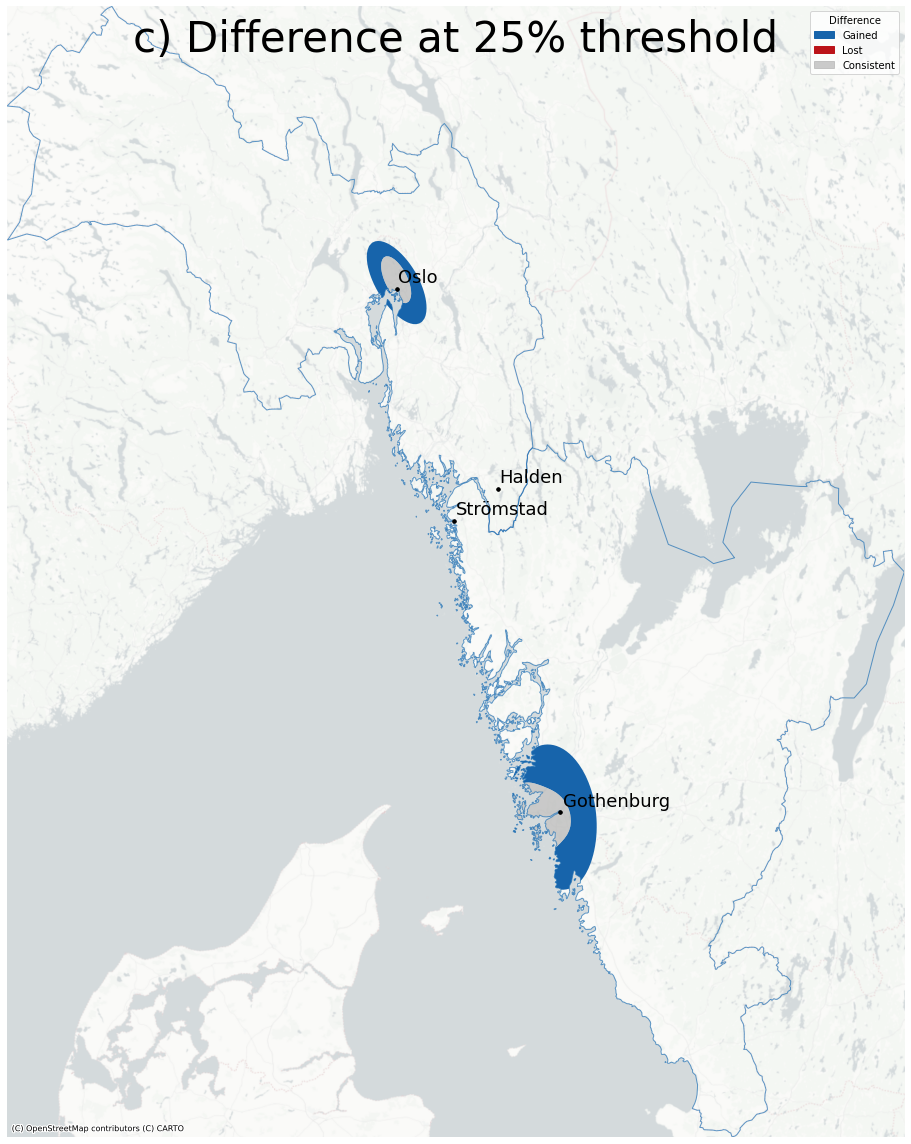

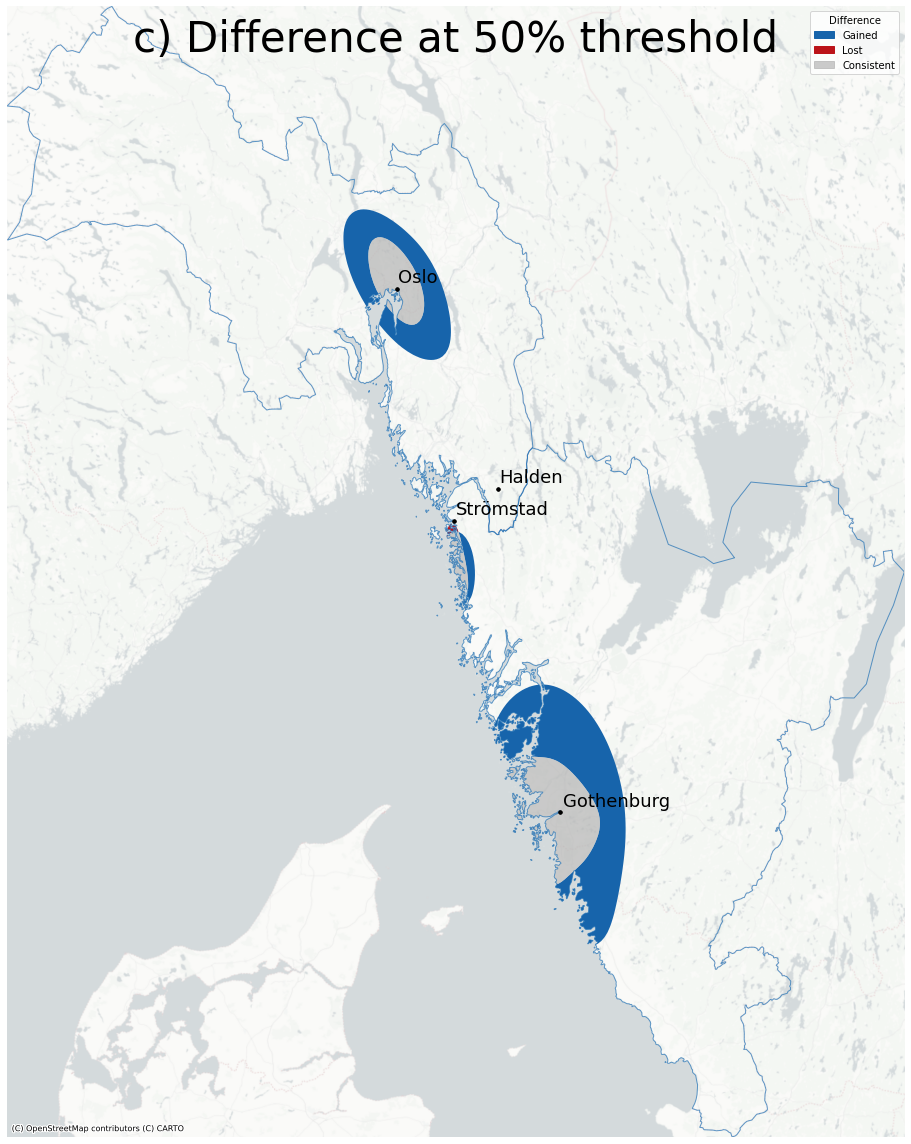

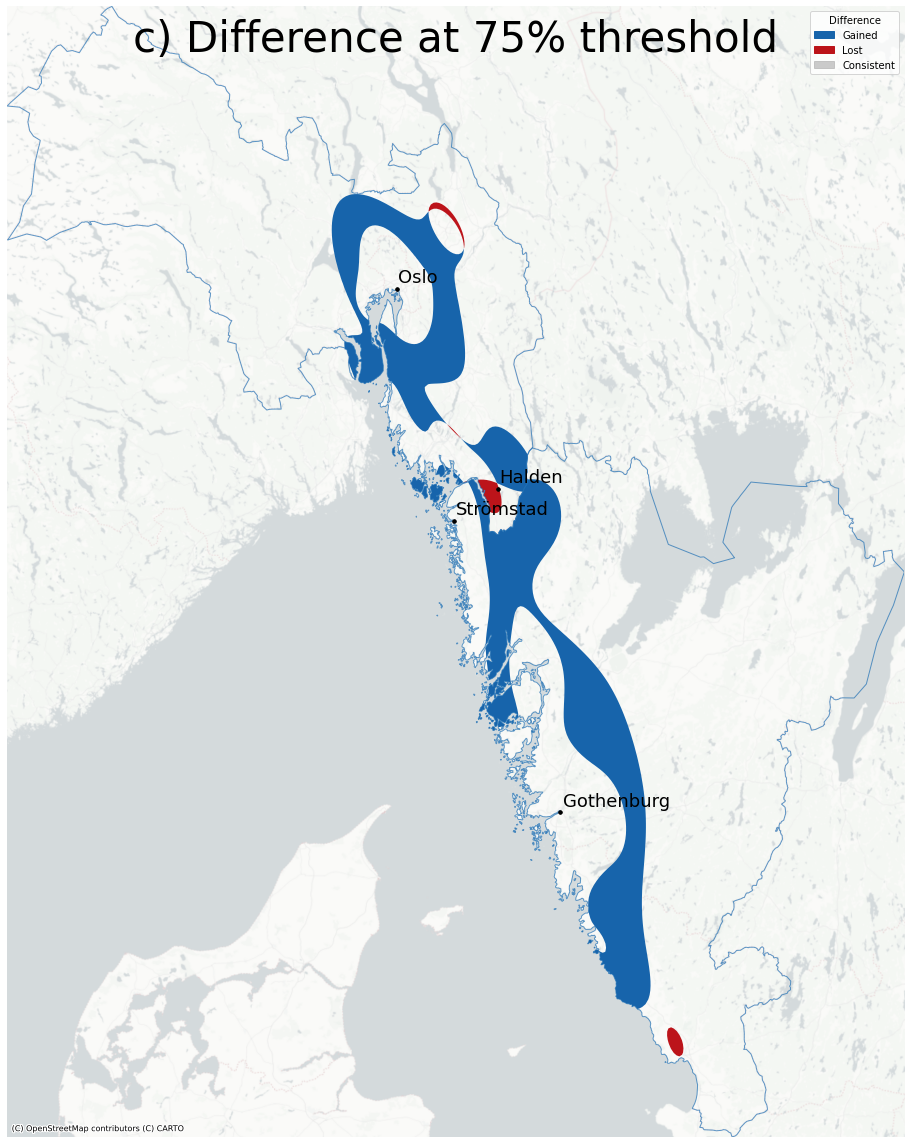

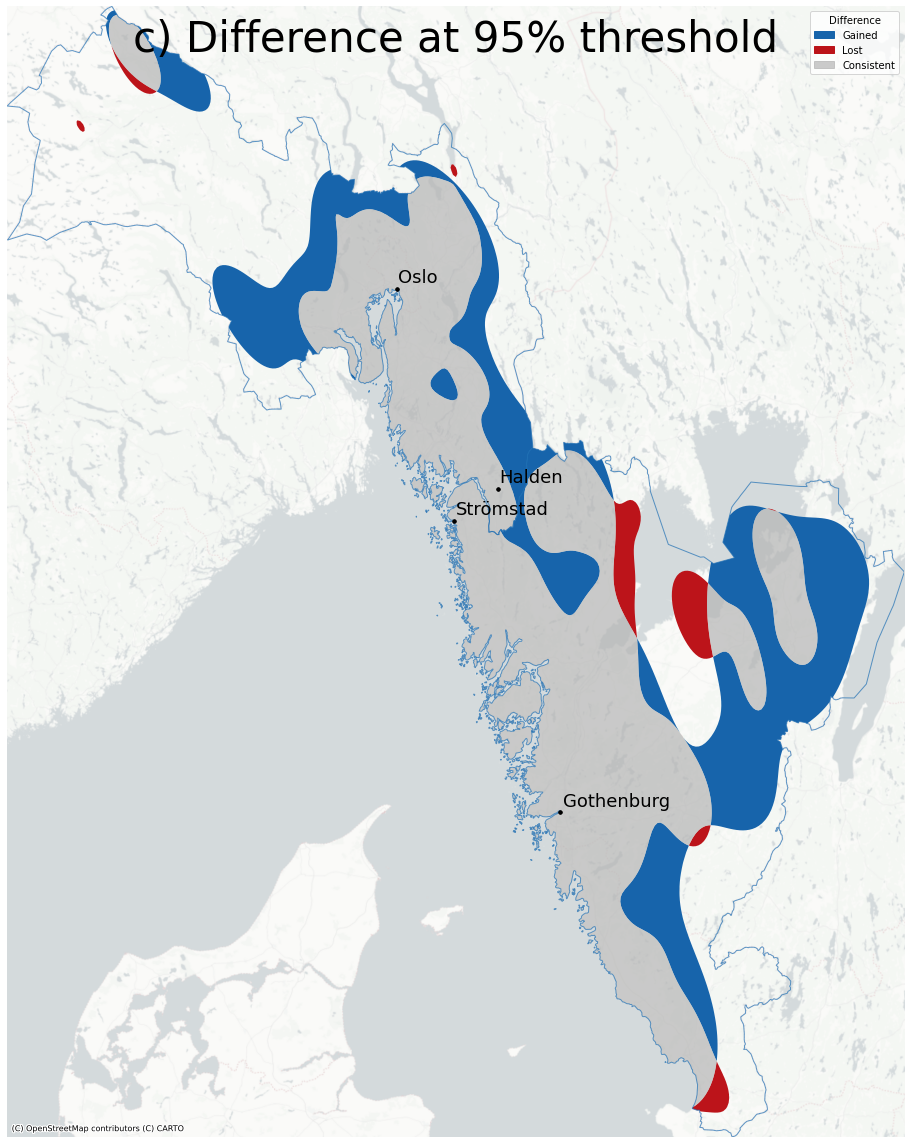

In [12]:
get_difference("NO08","SE23")
